[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lsizaguirre/09MIAR-TFM/blob/main/notebooks/BERT-sentiment-analysis/BERT-sentiment-analysis-fine-tunning.ipynb)

<div>
<img src="https://www.dropbox.com/s/crnfuz6kotkjzxa/viu_logo.png?dl=1" width="300"/>
</div>

## 09MIAR - TFM
### Análisis de Sentimiento

*por Luis Arturo Izaguirre Viera - lsizaguirre@gmail.com*

---

Para realizar este experimento, se ha tomado como base el como base el código fuente suministrado por Tensorflow para hacer fine-tunning del proceso de BERT.

source: https://www.tensorflow.org/text/tutorials/fine_tune_bert

# Librerias y Entorno

## Instalando librerias

Utilizamos las últimas versiones de las librerias que nos proporcionan acceso al modelo y a las funciones oficiles de BERT (official.nlp.bert)

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q -U tf-models-official==2.7.0
!pip install -q -U tfds-nightly

Se instalan las librerias de Tensorflow Hub y Keras para construir el modelo

In [2]:
!pip install -q -U tensorflow_hub
!pip install -q -U keras

## Importando librerias

Se importan las librerías que serán necesarias durante la ejecucion del experimento

In [3]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
from bs4 import BeautifulSoup
import re, string

import matplotlib.pyplot as plt

## Obteniendo información del entorno

Algunos scripts de código solo para obtener información del entorno

In [4]:
! python --version

Python 3.7.13


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print('Not connected to a TPU runtime')

1 Physical GPUs, 1 Logical GPUs
TF Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available
Not connected to a TPU runtime


# Datos

## Carga de dataset

Se monta el Google Drive y se carga el csv del dataset IMDB

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/dataset/IMDB-dataset.csv'
                ,encoding='ISO-8859-1')

## Inspección de los datos

In [8]:
#Para poder observar mejor las reseñas
pd.set_option('max_colwidth', 100)

In [9]:
#Inspeccionamos las primeras 10 reseñas del dataset
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a nobl...",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have tod...,positive
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 o...",negative
8,Encouraged by the positive comments about this film on here I was looking forward to watching th...,negative
9,If you like original gut wrenching laughter you will like this movie. If you are young or old th...,positive


In [10]:
# Obtenemos un poco más de información del dataframe
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not solely cooking (which would have been great too)....,positive
freq,5,25000


In [11]:
# Confirmamos que existen registros duplicados
pd.concat(g for _, g in df.groupby("review") if len(g) > 1)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promi...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promi...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's clos...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's clos...",negative
2976,"""Witchery"" might just be the most incoherent and lamentably scripted horror movie of the 80's bu...",negative
...,...,...
47876,this movie sucks. did anyone notice that the entire movie was shot in like 2 rooms. there are NE...,negative
23056,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at...",negative
44122,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at...",negative
10163,"when I first heard about this movie, I noticed it was one of the most controversial films of the...",positive


positive    25000
negative    25000
Name: sentiment, dtype: int64

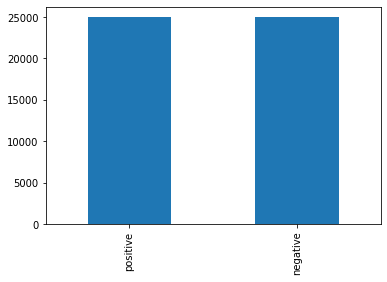

In [12]:
#Inspeccionamos como están distribuidos los valores de las etiquetas
df['sentiment'].value_counts().plot(kind='bar')
df['sentiment'].value_counts()

En este punto podemos concluir:


* El data set esta compuesto de 50.000 registros
* Para cada registro contamos con 2 columnas, la reseña (review) y el sentimiento (sentiment)
* El sentimiento contiene solo dos valores (positive y negative)
* El dataset esta perfectamente balanceado en cuanto a las etiquetas con 25.000 registros etiquetados como posittivos y 25.000 registros etiquetados como negativos.
* Existen registros duplicados por lo que procederemos a hacer un filtrado de los datos

PD: La distribución de clases nos ayuda mucho en la clasificación de textos. Imaginemos una situación en la que el 95% de los datos se encuentran en una clase y el 5% restante se divide entre otras 5 clases. Si no hiciéramos nada al respecto, el modelo simplemente aprendería a adivinar la clase del 95% todo el tiempo y estaría en lo correcto el 95% de las veces con los datos que usaríamos.




## Filtrado de los datos

In [13]:
#Procedemos a eliminar los registros duplicados del dataset.
df = df.drop_duplicates()

In [14]:
#Obtenemos las dimensiones del dataframe despues del filtrado de duplicados.
shape = df.shape
print('\nDataFrame Shape :', shape)
print('\nNumber of rows :', shape[0])
print('\nNumber of columns :', shape[1])


DataFrame Shape : (49582, 2)

Number of rows : 49582

Number of columns : 2


## Limpieza de datos

Debido a la naturaleza de los reviews, construiremos una funcion de limpieza que permita:
* Remover etiquetas HTML en la reseña.
* Eliminar textos entre corchetes.
* Eliminar signos de puntuación.

De esta forma eliminamos elementos que puedan causar ruido y obtendremos un mejor performance del modelo.



In [15]:
#Eliminando etiquetas HTML
def remove_html_tags(text):
    return re.sub('<.*?>', '', text)

#Eliminando textos entre corchetes
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Eliminando signos de puntuación
def remove_string_punctuation(text):
    text = text.translate(text.maketrans('', '', string.punctuation))
    return text

#Funcion de limpieza
def denoise_text(text):
    text = remove_html_tags(text)
    text = remove_between_square_brackets(text)
    text = remove_string_punctuation(text)
    return text

In [16]:
# Visualizamos un review antes de aplicar la funcion de limpieza
df['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

In [17]:
#Aplicando la función de limpieza al dataframe
df['review']=df['review'].apply(denoise_text)

In [18]:
# Visualizamos un review antes de aplicar la funcion de limpieza
df['review'][4]

'Petter Matteis Love in the Time of Money is a visually stunning film to watch Mr Mattei offers us a vivid portrait about human relations This is a movie that seems to be telling us what money power and success do to people in the different situations we encounter This being a variation on the Arthur Schnitzlers play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has a sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitatThe only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits A big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounterThe acting i

Para comenzar a construir el modelo procederemos a:

1.   Dividir los datos en los datasets de entrenamiento y pruebas
2.   Codificar las etiquetas
3.   Tokenizar el texto

## Split Entrenamiento y Pruebas

Tomamos el 20% de los datos como datos de prueba

In [19]:
x = df.review.values
y = df.sentiment.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [20]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

result_train = np.column_stack((unique_train, counts_train))
result_test = np.column_stack((unique_test, counts_test))

print (f'Valores y cantidad de datos para el conjunto de entrenamiento: \n {result_train} \n')
print (f'Valores y cantidad de datos para el conjunto de prueba: \n {result_test} \n')

Valores y cantidad de datos para el conjunto de entrenamiento: 
 [['negative' 19759]
 ['positive' 19906]] 

Valores y cantidad de datos para el conjunto de prueba: 
 [['negative' 4939]
 ['positive' 4978]] 



## Label Encoding

Se construye un Encoder para las etiquetas pensando que el problema puede adaptarse a un problema que no sea de clasificación binaria.

In [21]:
encoder = LabelEncoder()
encoder.fit(y)

encoder.classes_

array(['negative', 'positive'], dtype=object)

In [22]:
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

In [23]:
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# Se convierte el vector de clases (enteros 0 ó 1) a una matriz de clase binaria.
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

Se almacena el mapeo del encoding.

In [24]:
encoder_fname = 'imdb_encoder_classes.npy'
my_wd = '/content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/assets/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

Código para cargar el encoder.

In [25]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization


Para tokenizar el texto, se usan algunas funciones del paquete "official.nlp.bert" y el propio modelo BERT preentrenado.

In [26]:
# Primero se obtiene el modelo BERT
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [27]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Del modelo BERT preentrenado se obtienen algunas variables: 

1.   ```vocab_file``` es el conjunto de palabras sobre el que el modelo fue entrenado.
2.   ```do_lower_case``` variable booleana. Si es ```True``` significa que el tokenizador reformateará todo el texto en minúsculas para que **NO** distinga entre mayúsculas y minúsculas. Por defecto es ```False```.


In [28]:
#Primeras 5 líneas del vocab_file
f = open(vocab_file, 'r')
for i in range(5):
  word = f.readline()
  print(word)

[PAD]

[unused1]

[unused2]

[unused3]

[unused4]



In [29]:
# Minúscula? Uncased?
do_lower_case

False

Con las variables recogidas se instancia el Tokenizador

In [30]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [31]:
tokenizer.tokenize('Hello how are your printer?')

['Hello', 'how', 'are', 'your', 'print', '##er', '?']

Ids de los tokens de Clasificación y Separación

In [32]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Kewl, by this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

In [33]:
#Tokeniza y devuelve ids
def encode_reviews(r):
   tokens = list(tokenizer.tokenize(r))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([encode_reviews(r) for r in x_train])

In [34]:
print('Forma de los reviews tokenizados', reviews.shape.as_list())

Forma de los reviews tokenizados [39665, None]


In [35]:
lens = [len(i) for i in x_train]

In [36]:
max_seq_length = max(lens)
print('La longitud máxima es:', max_seq_length)

La longitud máxima es: 12219


Proceso de tokenización. Texto a TokensIDs

In [37]:
x_train[0]

'I really liked the movie The Emporers New Groove but watching this was like coming home and seeing your wife having relations with a llama Seriously this movie was bad Its like Club Dread after Super Troopers I am supposed to write 10 lines but I dont even know what else to say I laughed a couple of times but only because I was drinking A movie like that should at least be funny when your drunk It was not Maybe llamas are just funny and regular cartoon people arent Either way just stick with The Emporers New Groove if you want a funny cartoon llamathemed movie Line 10 is this line right here'

In [38]:
tokenizedReview = tokenizer.tokenize(x_train[0])
for i in tokenizedReview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

I [146]
really [30181]
like [11850]
##d [10162]
the [10105]
movie [18379]
The [10117]
Em [11289]
##pore [62758]
##rs [10943]
New [10287]
Groove [76502]
but [10473]
watching [84532]
this [10531]
was [10134]
like [11850]
coming [23959]
home [11816]
and [10111]
seeing [57039]
your [20442]
wife [14384]
having [13677]
relations [19824]
with [10169]
a [169]
llama [47281]
Seri [48939]
##ously [47173]
this [10531]
movie [18379]
was [10134]
bad [15838]
Its [14864]
like [11850]
Club [11316]
Dre [72531]
##ad [11488]
after [10662]
Super [12786]
T [157]
##ro [10567]
##oper [56361]
##s [10107]
I [146]
am [10392]
supposed [59516]
to [10114]
write [28685]
10 [10150]
lines [19515]
but [10473]
I [146]
dont [11758]
even [13246]
know [21852]
what [12976]
else [40843]
to [10114]
say [23763]
I [146]
lau [27207]
##ghed [75395]
a [169]
couple [20969]
of [10108]
times [13465]
but [10473]
only [10893]
because [12373]
I [146]
was [10134]
drinking [68351]
A [138]
movie [18379]
like [11850]
that [10189]
should [14

Se añade token [CLS] al inicio de cada frase

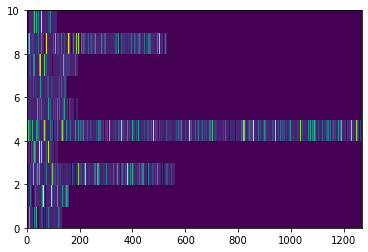

In [39]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

Lo que se observa arriba es una representación gráfica de las reseñas tokenizadas. El primer token es el token de clasificación. Los bloques de otros colores además del fondo son otros tokens.

## Mask_ids and input_type

El modelo espera dos tipos de entradas adicionales:

* masks_ids
* input_type

La máscara permite al modelo identificar de una forma sencilla entre el contenido y laparte que es relleno o padding. Tiene la misma forma que el `input_word_ids`, y contiene un `1` en aquellas posiciones donde `input_word_ids` no tiene un padding.

In [40]:
# Se truncan todas las entradas a un máximo de 512 tokens de longitud.

input_word_ids = input_word_ids[:,0:512]

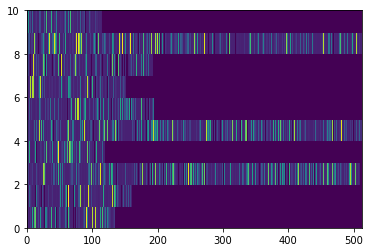

In [41]:
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

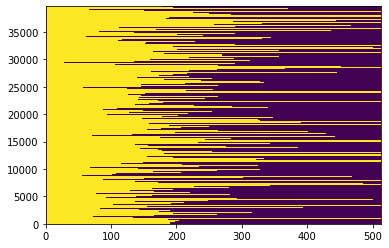

In [42]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

Cada bloque amarillo tiene alguna entrada. Se hace esto para que el modelo difiera entre el relleno y la entrada.

In [43]:
reviews = reviews[:,0:511]

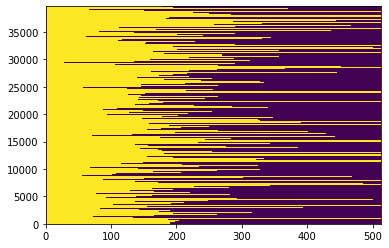

In [44]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

Se agrega un bloque vacío delante de cada tweet para el token `[CLS]`. Esto se puede observar en el tensor abajo

In [45]:
input_type_ids

<tf.Tensor: shape=(39665, 512), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## Función construcción entrada

En este punto se cuenta con las 3 entradas requeridas:

1.   Tokens
2.   Input mask
3.   Input type

Se construye todo en funciones para hacer el desarrollo más fácil. Podemos hacer la construcción de la entrada de forma manual como propone el código original o podemos usar la función `tokenizer.encode_plus()` de la libreria transformers de HugginFace que realiza el trabajo de forma automatizada.

In [46]:
#Definimos la secuencia máxima a la longitud por la que truncamos las entradas max_seq_length.
max_seq_length = 512
print('Max length is:', max_seq_length)

Max length is: 512


In [47]:
# Importamos Transformer
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 8.2 MB/s 
     |████████████████████████████████| 880 kB 64.8 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 6.6 MB 71.7 MB/s 


In [48]:
#Se instancia el tokenizador
from transformers import BertTokenizer

bertTokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [49]:
# Función.
def bert_encode(sentences, tokenizer, max_seq_length):

    input_ids = []
    attention_masks = []
    token_type_ids = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_seq_length,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_token_type_ids = True,   # Construct attn. masks.
                        return_tensors = 'tf',     # Return tensorflow tensors.
                   )
    
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
    
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        # And its token_type_ids
        token_type_ids.append(encoded_dict['token_type_ids'])

    # Convert the lists into tensors.
    # input_ids = torch.cat(input_ids, dim=0)
    # attention_masks = torch.cat(attention_masks, dim=0)
    # labels = torch.tensor(labels)
    
    inputs = {
      'input_word_ids': tf.squeeze(tf.convert_to_tensor(input_ids)),
      'input_mask': tf.squeeze(tf.convert_to_tensor(attention_masks)),
      'input_type_ids': tf.squeeze(tf.convert_to_tensor(token_type_ids)) }

    return inputs

In [50]:
word_test = bert_encode(['Esta es una frase', 'Otra frase'], bertTokenizer, max_seq_length)
print(word_test)

{'input_word_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[  101, 12890,  1161, ...,     0,     0,     0],
       [  101,   184,  4487, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}


In [51]:
# Con la función construida se procesan las entradas. Entrenamiento y Pruebas

X_train = bert_encode(x_train, bertTokenizer, max_seq_length)
X_test = bert_encode(x_test, bertTokenizer, max_seq_length)

# Modelado y Fine Tunning

## Entrenamiento Inicial

Necesitamos configurar nuestro modelo usando las entradas que hicimos, el modelo BERT que descargamos y una capa de salida basada en la cantidad de clases que estamos usando.

In [52]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [53]:
[input_word_ids, input_mask, segment_ids]

[<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'segment_ids')>]

El modelo.

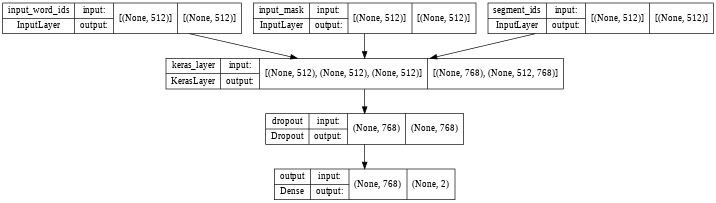

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up de los hiperparámetros.

In [55]:
epochs = 3
batch_size = 8 
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compilar el modelo.

In [56]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

Se almacena la historia para hacerle seguimiento posteriormente

In [58]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)    

Epoch 1/3
4959/4959 [==============================] - 3387s 680ms/step - loss: 0.4759 - accuracy: 0.7706 - val_loss: 0.3462 - val_accuracy: 0.8656
Epoch 2/3
4959/4959 [==============================] - 3369s 679ms/step - loss: 0.3328 - accuracy: 0.8928 - val_loss: 0.3936 - val_accuracy: 0.8878
Epoch 3/3
4959/4959 [==============================] - 3369s 679ms/step - loss: 0.2565 - accuracy: 0.9345 - val_loss: 0.4660 - val_accuracy: 0.8925


Evaluación

In [59]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9588
Testing Accuracy:  0.8925


Se grafican los resultados

In [60]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

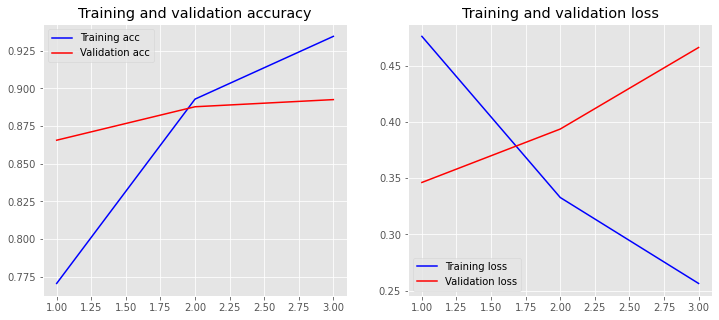

In [61]:
plot_history(history)

## Almacenamiento del modelo 

para uso posterior

In [62]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [63]:
model_fname = 'imdb_bert_model'
my_wd = '/content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/assets/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/assets/imdb_bert_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/assets/imdb_bert_model/assets


### Validar el modelo guardado

In [64]:
model_fname = 'imdb_bert_model'
my_wd = '/content/gdrive/MyDrive/VIU-MIAR/09MIAR-TFM/BERT-sentiment-analysis/assets/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [65]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8925


In [66]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

Se carga tambien el tokenizador.

In [67]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

Probamos el tokenizador.

In [68]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

I [146]
really [30181]
like [11850]
##d [10162]
the [10105]
movie [18379]
The [10117]
Em [11289]
##pore [62758]
##rs [10943]
New [10287]
Groove [76502]
but [10473]
watching [84532]
this [10531]
was [10134]
like [11850]
coming [23959]
home [11816]
and [10111]
seeing [57039]
your [20442]
wife [14384]
having [13677]
relations [19824]
with [10169]
a [169]
llama [47281]
Seri [48939]
##ously [47173]
this [10531]
movie [18379]
was [10134]
bad [15838]
Its [14864]
like [11850]
Club [11316]
Dre [72531]
##ad [11488]
after [10662]
Super [12786]
T [157]
##ro [10567]
##oper [56361]
##s [10107]
I [146]
am [10392]
supposed [59516]
to [10114]
write [28685]
10 [10150]
lines [19515]
but [10473]
I [146]
dont [11758]
even [13246]
know [21852]
what [12976]
else [40843]
to [10114]
say [23763]
I [146]
lau [27207]
##ghed [75395]
a [169]
couple [20969]
of [10108]
times [13465]
but [10473]
only [10893]
because [12373]
I [146]
was [10134]
drinking [68351]
A [138]
movie [18379]
like [11850]
that [10189]
should [14

# Evaluación

Obtenemos las clases y el encoder

In [ ]:
encoder_fname = 'imdb_classes.npy'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

Clases para el modelo.

In [ ]:
encoder.classes_

Preprocesado de la entrada.

In [ ]:
input = ['Fui a ver la pelicula pensando que era muy mala pero resulto ser una pelicula muy buena. Las actuaciones fueron fascinantes y el guión me encanto']
inputs = bert_encode(string_list=list(input), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=512)

Prediction.

In [ ]:
prediction = model.predict(inputs)
print(prediction)
print('Input is', 'positive' if encoder.classes_[np.argmax(prediction)]=='positive' else 'negative')